In [1]:
import os
import sys
import pandas as pd
import textdistance
import tqdm
import seaborn as sns
import selfies as sf
import matplotlib.pyplot as plt\

In [2]:
class CONFIGS:
    def __init__(self):
        self.NUM_IDX = 5
        self.INPUT_DIR = {
            'stoned':os.path.join('stoned'),
            'selfedit':os.path.join('analysis', 'outputs_1_evaluate_property_similarity_scores')
        }
        self.OUTPUT_DIR = os.path.join('analysis', 'outputs_3_draw_selfies_collapse')
        if not os.path.exists(self.OUTPUT_DIR):
            os.mkdir(self.OUTPUT_DIR)
    
configs = CONFIGS()

## Generated molecules

In [3]:
df_stoned_qed = pd.read_pickle(os.path.join(configs.INPUT_DIR['stoned'], 'stoned_{}_top_sel.pkl'.format('qed'))).reset_index(drop=True)
df_stoned_drd2 = pd.read_pickle(os.path.join(configs.INPUT_DIR['stoned'], 'stoned_{}_top_sel.pkl'.format('drd2'))).reset_index(drop=True)

In [4]:
df_selfedit_qed = pd.read_csv(os.path.join(configs.INPUT_DIR['selfedit'], 'qed', 'generated_edit_iter{}.csv'.format(2)))
df_selfedit_drd2 = pd.read_csv(os.path.join(configs.INPUT_DIR['selfedit'], 'drd2', 'generated_edit_iter{}.csv'.format(2)))

In [5]:
selfies_ctrl_qed = df_stoned_qed.loc[:,'selfies'].values.tolist()
selfies_ctrl_drd2 = df_stoned_drd2.loc[:,'selfies'].values.tolist()

In [6]:
selfies_test_qed = df_selfedit_qed.loc[:,'SELFIES_opt'].values.tolist()
selfies_test_drd2 = df_selfedit_drd2.loc[:,'SELFIES_opt'].values.tolist()

## Levenshtein distance 

In [7]:
def calc_lev_score(sel):
    rec = sf.encoder(sf.decoder(sel))
    
    sel_tokens = list(sf.split_selfies(sel))
    rec_tokens = list(sf.split_selfies(rec))
    
    return textdistance.levenshtein.distance(sel_tokens, rec_tokens)

In [20]:
def make_lev_dataframe(selfies_ctrl, selfies_test, labels={'ctrl':'STONED', 'test':'SELF-EdiT'}):
    df_ctrl = pd.Series(selfies_ctrl, name='SELFIES').to_frame()
    for i in tqdm.trange(len(df_ctrl)):
        df_ctrl.loc[i,'Levenshtein Distance'] = calc_lev_score(df_ctrl.loc[i,'SELFIES'])
        df_ctrl.loc[i,'Levenshtein Distance'] = df_ctrl.loc[i,'Levenshtein Distance'].astype(int)
    df_ctrl.loc[:,'Collapse Rates'] = f"{labels['ctrl']} ({(df_ctrl.loc[:,'Levenshtein Distance'] > 0).value_counts()[True] / len(df_ctrl):.3f})"
    
    df_test = pd.Series(selfies_test, name='SELFIES').to_frame()
    for i in tqdm.trange(len(df_test)):
        df_test.loc[i,'Levenshtein Distance'] = calc_lev_score(df_test.loc[i,'SELFIES'])
        df_test.loc[i,'Levenshtein Distance'] = df_test.loc[i,'Levenshtein Distance'].astype(int)
    df_test.loc[:,'Collapse Rates'] = f"{labels['test']} ({(df_test.loc[:,'Levenshtein Distance'] > 0).value_counts()[True] / len(df_test):.3f})"
    
    return pd.concat((df_test, df_ctrl), ignore_index=True) 

In [21]:
df_qed = make_lev_dataframe(selfies_ctrl_qed, selfies_test_qed)
df_drd2 = make_lev_dataframe(selfies_ctrl_drd2, selfies_test_drd2)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:36<00:00, 546.67it/s]


# Draw plot

In [22]:
df_qed_nonzero = df_qed[(df_qed['Levenshtein Distance'] > 0) & (df_qed['Levenshtein Distance'] < 11)].reset_index(drop=True)
df_drd2_nonzero = df_drd2[(df_drd2['Levenshtein Distance'] > 0) & (df_drd2['Levenshtein Distance'] < 11)].reset_index(drop=True)

In [23]:
df_qed_nonzero

,SELFIES,Levenshtein Distance,Collapse Rates
0,[Branch1][N][NH2+1][C][C][Branch1][C][C][Branc...,1.0,SELF-EdiT (0.114)
1,[C][Branch1][C][N][Branch2][Ring1][C][C][=C][C...,1.0,SELF-EdiT (0.114)
2,[=C][C][=Branch1][Ring2][=C][Ring1][=Branch2][...,2.0,SELF-EdiT (0.114)
3,[C][N][=C][N][=C][Branch1][N][N][N][=C][Branch...,4.0,SELF-EdiT (0.114)
4,[O][=C][N][=C][C][Branch1][C][Cl][=C][Ring1][#...,2.0,SELF-EdiT (0.114)
...,...,...,...
11157,[C][=C][Branch1][N][C][O][C][Branch1][=C][N][C...,6.0,STONED (0.649)
11158,[C][C][=C][N][Branch1][=Branch1][C][C][Ring1][...,4.0,STONED (0.649)
11159,[C][Branch1][C][O][C][=C][C][Branch1][C][Br][=...,1.0,STONED (0.649)
11160,[C][Branch2][Ring1][=Branch2][C][N][Branch1][S...,4.0,STONED (0.649)


In [24]:
df_drd2_nonzero

,SELFIES,Levenshtein Distance,Collapse Rates
0,[C][NH1+1][=C][N][C][C][C][N][C][=Branch1][C][=O],2.0,SELF-EdiT (0.233)
1,[Branch1][#C][C][=N][C][=C][Branch1][Ring2][S]...,2.0,SELF-EdiT (0.233)
2,[Branch2][Ring1][C][C][C][=C][Branch1][Branch1...,2.0,SELF-EdiT (0.233)
3,[Branch1][=C][O][C][C][C][=C][Branch1][C][C][N...,2.0,SELF-EdiT (0.233)
4,[Branch2][Ring1][C][C][=C][C][=C][O][C][C][=Br...,2.0,SELF-EdiT (0.233)
...,...,...,...
12223,[C][C][N][Branch1][#Branch1][C][C][C][C][Ring1...,2.0,STONED (0.499)
12224,[C][=C][C][=Branch2][Ring1][#Branch1][=C][C][=...,5.0,STONED (0.499)
12225,[N][Branch1][=N][C][C][C][N][C][C][C][C][C][Ri...,1.0,STONED (0.499)
12226,[C][C][N][Branch1][N][C][C][=C][C][=Branch1][B...,5.0,STONED (0.499)


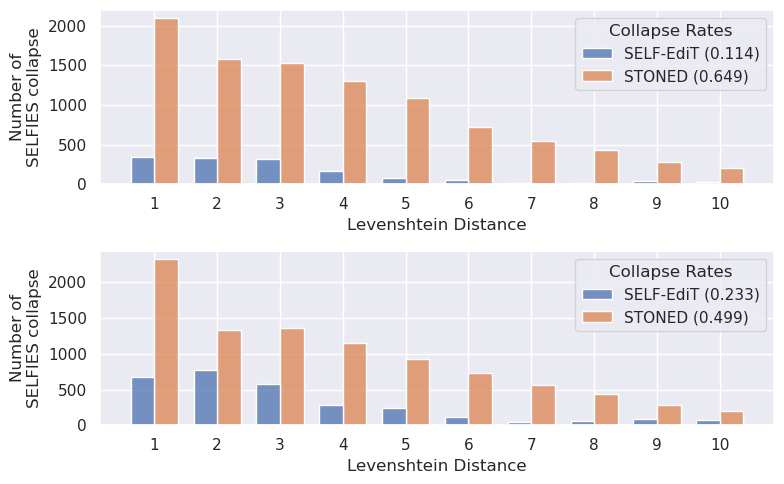

In [25]:
sns.set_theme(style='darkgrid')

fig, ax = plt.subplots(2,1,figsize=(8,5))

_ = sns.histplot(
    data=df_qed_nonzero,
    x='Levenshtein Distance',
    hue='Collapse Rates',
    discrete=True,
    multiple='dodge',
    shrink=0.75,
    ax=ax[0],
)

_ = sns.histplot(
    data=df_drd2_nonzero,
    x='Levenshtein Distance',
    hue='Collapse Rates',
    discrete=True,
    multiple='dodge',
    shrink=0.75,
    ax=ax[1],
)

for i in range(2):
    ax[i].set_xticks(range(1,11))
    ax[i].set_ylabel('Number of\nSELFIES collapse')

plt.tight_layout()
#plt.show()
plt.savefig(os.path.join(configs.OUTPUT_DIR, 'histplots_qed_drd2.png'), dpi=300)